In [21]:
from time import time, localtime
import numpy as np
from utils import plot_graph
import tensorflow_federated as tff
import tensorflow as tf
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from keras import losses, metrics, optimizers
import random
import pandas as pd
import sys
import matplotlib.pyplot as plt
import nest_asyncio
from pathlib import Path
from checkpoint_manager import FileCheckpointManager
import tensorflow_addons as tfa
nest_asyncio.apply()
SEED = 1337
tf.random.set_seed(SEED)


Lựa chọn model <br>
Thay models.<Ten_model>

In [22]:
from models.CNNv5 import create_keras_model


Thay đổi các siêu tham số trong cell dưới <br>
**experiment_name:** Tên bộ dữ liệu được sử dụng, <Tên dữ liệu>_<Số byte sử dụng> <br>
**method:** Mô hình sử dụng <br>
**client_lr, server_lr:** Learning rate của client và server, khi fine tune bắt đầu từ 1 và giảm dần xuống 3e-4 <br>
**NUM_ROUNDS:** Số vòng lặp (Bắt đầu từ 1 và tăng dần lên 3000 nếu mô hình chưa hội tụ - 1/100/200/300/400/500/.../3000) <Br>
**BATCH_SIZE:** Kích thước batch (Bắt đầu từ 8 và tăng dần lên 64) 8/16/32/64 <br>
**split:** Để nguyên là 5

byte_number (string): Cac byte cua packet, bao gom 10, 32, 64, 128, 256, 512, 1024, 1460

In [23]:
byte_number = "512"


In [24]:
experiment_name = "GQUIC_" + byte_number
method = "nonFL_CNNv5_with_length"
client_lr = 1e-3
NUM_ROUNDS = 100
BATCH_SIZE = 100


In [25]:
this_dir = Path.cwd()
model_dir = this_dir / "sdn_saved_models" / experiment_name / method
output_dir = this_dir / "sdn_results" / experiment_name / method

if not model_dir.exists():
    model_dir.mkdir(parents=True)

if not output_dir.exists():
    output_dir.mkdir(parents=True)


In [26]:
def sec_to_hours(seconds):
    a = seconds//3600
    b = (seconds % 3600)//60
    c = (seconds % 3600) % 60
    d = "{:.0f} hours {:.0f} mins {:.0f} seconds".format(a, b, c)
    return d


In [27]:
def most_frequent(List):
    return max(set(List), key=List.count)


### Đọc dữ liệu

In [28]:
train_dir = '/home/onos/FL/Data Processing/GQUIC_data_' + byte_number + '.csv'
test_dir = '/home/onos/FL/Data Processing/GQUIC_test_' + byte_number + '.csv'
data = pd.read_csv(train_dir, engine='pyarrow')
test = pd.read_csv(test_dir, engine='pyarrow')


In [29]:
# data.drop(['length'],axis=1,inplace=True)
# test.drop(['length'],axis=1,inplace=True)


In [30]:

result = test.groupby('flow_id')['Label'].apply(list).to_dict()
flow_label = []
for flow in result:
    flow_label.append(most_frequent(result[flow]))


In [31]:
true_test = test.drop('flow_id', axis=1)


In [32]:
NUM_FEATURE = len(true_test.columns)-1
NUM_CLASSES = len(np.unique(true_test['Label']))
print(NUM_FEATURE, NUM_CLASSES)


513 4


In [33]:
y_test = true_test['Label'].to_numpy()
x_test = true_test.drop('Label', axis=1).to_numpy()
y_train = data['Label'].to_numpy()
x_train = data.drop(['Label'], axis=1).to_numpy()

In [34]:
# def sklearn_to_df(sklearn_dataset):
#     df = pd.DataFrame(sklearn_dataset.data,
#                       columns=sklearn_dataset.feature_names)
#     df['Label'] = pd.Series(sklearn_dataset.Label)
#     return df


In [35]:
# from sklearn import datasets
# df = sklearn_to_df(datasets.load_iris())


In [36]:
# train_data = train_data[0].concatenate(train_data[1])
# val_data = val_data[0].concatenate(val_data[1])


### Model Definition

In [37]:
model = create_keras_model(NUM_FEATURE, NUM_CLASSES)
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d_2 (Conv1D)           (None, 513, 32)           832       
                                                                 
 max_pooling1d_2 (MaxPooling  (None, 171, 32)          0         
 1D)                                                             
                                                                 
 conv1d_3 (Conv1D)           (None, 171, 64)           51264     
                                                                 
 max_pooling1d_3 (MaxPooling  (None, 57, 64)           0         
 1D)                                                             
                                                                 
 flatten_1 (Flatten)         (None, 3648)              0         
                                                                 
 dense_2 (Dense)             (None, 1024)             

In [38]:
model.compile(optimizer=tf.keras.optimizers.Adam(
    learning_rate=client_lr), loss=tf.keras.losses.SparseCategoricalCrossentropy(),
    metrics=[tf.keras.metrics.SparseCategoricalAccuracy()])
start = time()
history = model.fit(x_train, y_train, epochs=NUM_ROUNDS, batch_size=BATCH_SIZE,use_multiprocessing=True,shuffle=False)
end = time() - start

Epoch 1/100
8529/8529 [==============================] - 518s 61ms/step - loss: 1.0235 - sparse_categorical_accuracy: 0.5169
Epoch 2/100
8529/8529 [==============================] - 450s 53ms/step - loss: 0.9951 - sparse_categorical_accuracy: 0.5321
Epoch 3/100
8529/8529 [==============================] - 541s 63ms/step - loss: 0.9892 - sparse_categorical_accuracy: 0.5349
Epoch 4/100
8529/8529 [==============================] - 436s 51ms/step - loss: 0.9859 - sparse_categorical_accuracy: 0.5362
Epoch 5/100
8529/8529 [==============================] - 528s 62ms/step - loss: 0.9839 - sparse_categorical_accuracy: 0.5371
Epoch 6/100
8529/8529 [==============================] - 462s 54ms/step - loss: 0.9824 - sparse_categorical_accuracy: 0.5376
Epoch 7/100
8529/8529 [==============================] - 476s 56ms/step - loss: 0.9811 - sparse_categorical_accuracy: 0.5379
Epoch 8/100
8529/8529 [==============================] - 511s 60ms/step - loss: 0.9799 - sparse_categorical_accuracy: 0.5386


In [39]:
total_time = "Time: {}".format(sec_to_hours(end))
print(total_time)


Time: 11 hours 26 mins 31 seconds


### Evaluation

In [40]:
best_model_accuracy = history.history['sparse_categorical_accuracy'][np.argmin(history.history['loss'])]

In [41]:
_, test_acc = model.evaluate(x_test, y_test,verbose=2, batch_size=BATCH_SIZE,use_multiprocessing=True)

2133/2133 - 16s - loss: 1.1924 - sparse_categorical_accuracy: 0.5120 - 16s/epoch - 7ms/step


In [42]:
train_val = str(round(best_model_accuracy*100)) + "_" + str(round(test_acc*100))

In [43]:
this_dir = Path.cwd()
model_dir = this_dir / "sdn_saved_models" / experiment_name / method / train_val
output_dir = this_dir / "sdn_results" / experiment_name / method / train_val

if not model_dir.exists():
    model_dir.mkdir(parents=True)

if not output_dir.exists():
    output_dir.mkdir(parents=True)

In [44]:
model.save(model_dir/'model.h5')

In [45]:
with open(output_dir/'parameters.txt', 'w') as f:
    print('client_lr: {}\nEpochs: {}\nBATCH_SIZE: {}'.format(
        client_lr, NUM_ROUNDS, BATCH_SIZE), file=f)
    f.close()

In [46]:
text_file = open(output_dir/"time.txt", "w")
n = text_file.write(total_time)
text_file.close()

In [47]:
predictions = model.predict(x_test,verbose=2,use_multiprocessing=True,batch_size=BATCH_SIZE)

2133/2133 - 16s - 16s/epoch - 7ms/step


In [48]:
y_pred = np.argmax(predictions, axis=-1)
test['pred'] = y_pred.tolist()

In [49]:
result = test.groupby('flow_id')['pred'].apply(list).to_dict()
flow_pred = []
for flow in result:
    flow_pred.append(most_frequent(result[flow]))

In [50]:
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.metrics import classification_report


classes = []
for c in range(NUM_CLASSES):
    classes.append("Class {}".format(c))
print(classes)
with open(output_dir/'metrics.txt', 'w') as f:
    confusion = confusion_matrix(flow_label, flow_pred)
    print('Confusion Matrix\n', file=f)
    print(confusion, file=f)

    # importing accuracy_score, precision_score, recall_score, f1_score
    print('\nAccuracy: {:.2f}\n'.format(
        accuracy_score(flow_label, flow_pred)), file=f)

    print('Micro Precision: {:.2f}'.format(
        precision_score(flow_label, flow_pred, average='micro')), file=f)
    print('Micro Recall: {:.2f}'.format(
        recall_score(flow_label, flow_pred, average='micro')), file=f)
    print(
        'Micro F1-score: {:.2f}\n'.format(f1_score(flow_label, flow_pred, average='micro')), file=f)

    print('Macro Precision: {:.2f}'.format(
        precision_score(flow_label, flow_pred, average='macro')), file=f)
    print('Macro Recall: {:.2f}'.format(
        recall_score(flow_label, flow_pred, average='macro')), file=f)
    print(
        'Macro F1-score: {:.2f}\n'.format(f1_score(flow_label, flow_pred, average='macro')), file=f)

    print('Weighted Precision: {:.2f}'.format(
        precision_score(flow_label, flow_pred, average='weighted')), file=f)
    print('Weighted Recall: {:.2f}'.format(
        recall_score(flow_label, flow_pred, average='weighted')), file=f)
    print(
        'Weighted F1-score: {:.2f}'.format(f1_score(flow_label, flow_pred, average='weighted')), file=f)

    print('\nClassification Report\n', file=f)
    print(classification_report(flow_label, flow_pred, target_names=classes), file=f)
    f.close()


['Class 0', 'Class 1', 'Class 2', 'Class 3']


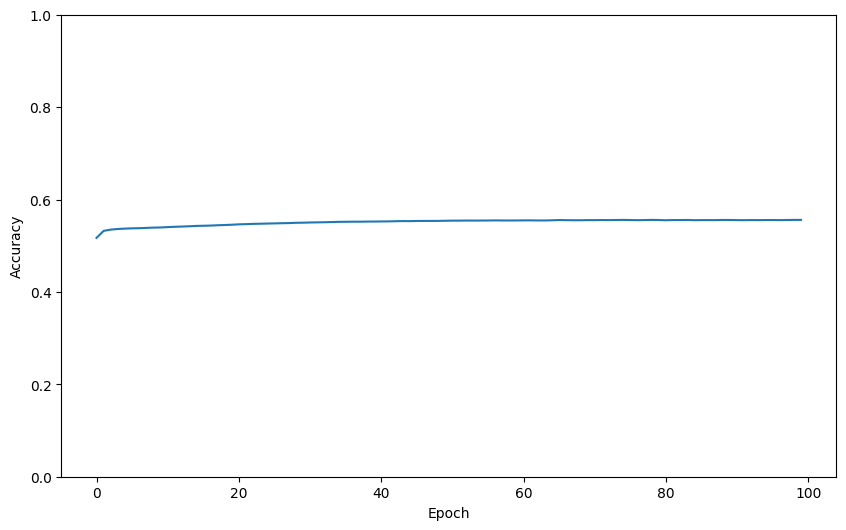

In [51]:
fig = plt.figure(figsize=(10, 6))
plt.plot(history.history['sparse_categorical_accuracy'], label='accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.ylim([0,1])
plt.savefig(output_dir / "normal_model_Accuracy.png")

In [58]:
data.shape[0]/20

42644.8

In [59]:
test.shape[0]

10661.2

In [56]:
data['flow_id'].nunique()

KeyError: 'flow_id'

In [60]:
test.head(20)

,flow_id,length,0,1,2,3,4,5,6,7,...,504,505,506,507,508,509,510,511,Label,pred
0,1,0.143820,0.878431,0.203922,0.003922,0.094118,0.545098,0.313725,0.145098,0.556863,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0,0
1,2,1.000000,0.321569,0.819608,0.443137,0.486275,0.188235,0.709804,0.152941,0.925490,...,0.525490,0.474510,0.078431,0.090196,0.211765,0.403922,0.349020,0.584314,0,3
2,2,0.010487,0.215686,0.427451,0.870588,0.070588,0.137255,0.921569,0.674510,0.800000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0,0
3,3,0.010487,0.266667,0.611765,0.678431,0.427451,0.827451,0.498039,0.137255,0.678431,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0,0
4,3,0.017228,0.011765,0.588235,0.333333,0.317647,0.600000,0.603922,0.243137,0.819608,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0,3
5,3,0.057678,0.149020,0.941176,0.600000,0.250980,0.023529,0.439216,0.949020,0.125490,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0,3
6,3,0.017228,0.443137,0.992157,0.666667,0.305882,0.196078,0.870588,0.098039,0.941176,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0,3
7,4,0.121348,0.474510,0.556863,0.909804,0.866667,0.341176,0.509804,0.796078,0.054902,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,3,3
8,4,0.013483,0.278431,0.211765,0.301961,0.149020,0.623529,0.568627,0.576471,0.800000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,3,3
9,4,0.017228,0.917647,0.572549,0.415686,0.011765,0.176471,0.066667,0.239216,0.329412,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,3,3


In [57]:
test['flow_id'].nunique()

76009